In [175]:
import numpy as np # for working with arrays
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
import math # for math
from scipy.interpolate import interp1d # for interpolating points

***Data collected as follows:***

For a leaf with an odd number of lobes, the central lobe with equal numbers of lobes on each side:

`blade_trace`: a text file of x and y coordinates of the polyline trace of the blade. In this example, the blade_trace file was made using the wand tool in ImageJ and saved using the `x and y coordinates` option as a text file.

`landmarks`: for a leaf with the tip pointing upwards and the petiole down, starting on the left side, for each lobe select landmarks at the start of the lobe (left side of base), the tip, and the end of the lobe (right side of base). In this example, the landmarks file was made using the point tool in ImageJ and save using the `x and y coordinates` option as a text file.

In [176]:
# read in data
blade_trace = np.loadtxt("./blade_trace.txt")
landmarks = np.loadtxt("./landmarks.txt")

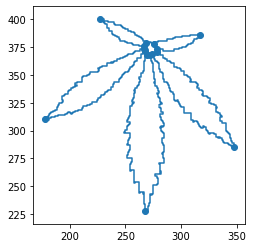

In [177]:
# plot to check data
plt.plot(blade_trace[:,0],blade_trace[:,1])
plt.scatter(landmarks[:,0],landmarks[:,1])
plt.gca().set_aspect("equal")

In [178]:
# define a function to return equally spaced, interpolated points for a given polyline
# inputs: arrays of x and y values for a polyline, number of points to interpolate
# ouputs: interpolated points along the polyline, inclusive of start and end points, as arrays

def interpolation(x, y, number): 

    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

In [179]:
# define a function to find corresponding index positions of landmarks in the trace file
# and return a trace file at higher resolution with more interpolated points
# inputs: arrays with x and y coordinates for the landmarks and trace, total resolution to interpolate over
# outputs: the indices of the landmarks in the returned modified trace files, now at specified resolution,
# and x and y coordinates at higher resolution as arrays

def highres_landmarking(landmarks_file, trace_file, resolution):
    
    trace_xvals = trace_file[:,0] # specify trace xvals
    trace_yvals = trace_file[:,1] # specify trace yvals

    trace_xvals, trace_yvals = interpolation(trace_xvals,trace_yvals,resolution) # interpolate points to achieve high resolution

    highres_xvals = trace_xvals # copy trace xvals to replace its trace vals with landmark vals
    highres_yvals = trace_yvals # copy trace yvals to replace its trace vals with landmark vals

    land_indices = [] # list to store index values of landmarks in trace

    for i in range(landmarks_file.shape[0]): # for each landmark

        landx = landmarks_file[i,0] # select current landmark x val
        landy = landmarks_file[i,1] # select current landmark y val

        distances = [] # list to store distances of current landmark with each trace coord

        for j in range(len(trace_xvals)): # for each trace coord

            tracex = trace_xvals[j] # current trace x val
            tracey = trace_yvals[j] # current trace y val

            d = np.sqrt( (landx-tracex)**2 + (landy-tracey)**2 ) # find distance to each landmark for each trace

            distances.append(d) # append distance of landmark to each trace val

        min_val = np.min(distances) # find min distance value of a trace for the landmark
        min_ind = distances.index(min_val) # find min index value among trace coords to the landmark

        land_indices.append(min_ind) # append trace index that corresponds to landmark
        
    return land_indices, highres_xvals, highres_yvals



In [180]:
# find landmark indices in the trace and return at higher resolution

resolution = 10000 # specify number of interpolated points to use

land_indices, highres_xvals, highres_yvals = highres_landmarking(landmarks, blade_trace, resolution)

In [181]:
# define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
# and p1 being the left hand of the angle
# inputs: three angle points, as tuples
# output: angle in degrees

def angle_between(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

# define a function to rotate 2D x and y coordinate points around the origin
# inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
# outputs: rotated and y vals

def rotate_points(xvals, yvals, degrees):
    
    angle_to_move = 270 - degrees # USE 270 DEGREES TO ORIENT TIP DOWNWARD
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

In [182]:
# rotate so that tip faces downward
# translate so that the petiolar junction is at the origin
# scale so that the central lobe is length of 1

highres_coords = np.column_stack((highres_xvals, highres_yvals)) # create a 2D array of x and y coords

tip_ind = land_indices[int( ((len(land_indices)/2) + 0.5) - 1 )] # find the tip index value
start_inds = land_indices[0::3] # find the start index value of each lobe
end_inds = land_indices[2::3] # find the end index value of each lobe

tip = highres_coords[int(tip_ind)] # get tip coordinates
pet_junc = np.mean(highres_coords[start_inds+end_inds], axis=0) # calculate petiolar junction coords as mean of start and end points of each lobe

# calculate angle between tip, petiolar junction, and a line extending right of petoilar junciton
angle = angle_between(tip, pet_junc, (pet_junc[0]+1,pet_junc[1]) ) 

# rotate leaf so that tip points downwards
rotated_xvals, rotated_yvals = rotate_points(highres_coords[:,0],highres_coords[:,1], angle)

# calculate coordinates of new rotated petiolar junction to translate leaf to the origin
origin_x, origin_y = np.mean(rotated_xvals[start_inds+end_inds]), np.mean(rotated_yvals[start_inds+end_inds])

# translate leaf to the origin
trans_xvals, trans_yvals = rotated_xvals - origin_x, rotated_yvals - origin_y

# calculate new tip points to scale central lobe legnth to 1
tip_x, tip_y = trans_xvals[int(tip_ind)], trans_yvals[int(tip_ind)]

# calculate central lobe length, from tip to origin
central_lobe_len = np.sqrt( (tip_x-0)**2 + (tip_y-0)**2 )

# calculate scaled coordinate values
scaled_xvals, scaled_yvals = trans_xvals/central_lobe_len, trans_yvals/central_lobe_len

# stack scaled coordinates back into a 2D array
leaf_coords = np.column_stack((scaled_xvals, scaled_yvals)) # create a 2D array of x and y coords


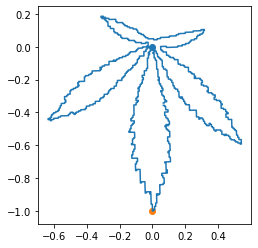

In [183]:
# plot to check data
plt.plot(leaf_coords[:,0], leaf_coords[:,1])
plt.scatter(0,0) # plot origin
plt.scatter(0,-1) # should be the tip
plt.gca().set_aspect("equal")

In [184]:
# reindex the coordinate values so that they begin with the first landmark

start_coordinate = leaf_coords[land_indices[0]] # save beginning coordinate to double check results

num_coords = np.shape(leaf_coords)[0] # get number of coordinate values
zero_index = land_indices[0] # get the zeroth index to start at

reindexed_arr = np.zeros((num_coords,2)) # array to store new vals

for i in range(num_coords):
    
    curr_ind = i # get current index
    new_ind = (i - zero_index)%num_coords # get the new index to use
    reindexed_arr[new_ind,:] = leaf_coords[curr_ind,:] # store the value at the new index position
    
print(start_coordinate, "\n", reindexed_arr[0]) # double check that the start value is now at position 0

[-0.02539892  0.04753531] 
 [-0.02539892  0.04753531]


In [185]:
# similar to above, reindex landmarks values the same way

num_coords = np.shape(leaf_coords)[0] # get number of coordinate values
zero_index = land_indices[0] # get the zeroth index to start at

reindexed_landmarks = [] # a list to store new landmark indices

for i in range(len(land_indices)):
    
    curr_ind_val = land_indices[i] # get current index
    new_ind_val = (curr_ind_val - zero_index)%num_coords # get the new index to use
    reindexed_landmarks.append(new_ind_val)
    
print(reindexed_landmarks) # double check that results worked

[0, 465, 947, 988, 2166, 3314, 3389, 5009, 6606, 6640, 7894, 9142, 9160, 9551, 9940]


In [307]:
num_lobes = int(len(reindexed_landmarks)/3) # get the number of lobes

#################################################################################
num_land = 200 # number of landmarks to interpolate over on each side of the lobe

tip_index = num_land - 1 # this will be the index of the tip

polar_lobe_angles = [] # a list of the angle of each lobe, from its tip to origin
polar_angles = [] # a list of lists of the angle values for each lobe point
polar_radii = [] # a list of lists of the radii values for each lobe point

for j in range(num_lobes): # for the number of lobes
    
    print(j)

    lobe_index = j # the index of the lobe to retrieve, starting at 0

    start_indices = reindexed_landmarks[0::3] # get the lobe start indices
    tip_indices = reindexed_landmarks[1::3] # get the lobe tip indices
    end_indices = reindexed_landmarks[2::3] # get the lobe end indices

    curr_start = start_indices[lobe_index] # for the current lobe, get the start index
    curr_tip = tip_indices[lobe_index] # for the current lobe, get the tip index
    curr_end = end_indices[lobe_index] # for the current lobe, get the end index

    right_side = reindexed_arr[curr_start:curr_tip+1] # get the right side of the lobe 
    left_side = reindexed_arr[curr_tip:curr_end+1] # get the left side of the lobe

    # note that left and right are relative to when the leaf was pointing upwards

    right_inter_x, right_inter_y = interpolation(right_side[:,0], right_side[:,1], num_land) # interpolate pseudolandmarks on right side
    left_inter_x, left_inter_y  = interpolation(left_side[:,0], left_side[:,1], num_land) # interpolate pseudolandmarks on left side

    right_inter = np.column_stack((right_inter_x, right_inter_y)) # recombine right coords
    right_inter = right_inter[0:-1,:] # remove the last value from the last side to avoid duplicate with left
    left_inter = np.column_stack((left_inter_x, left_inter_y)) # recombine left coords

    lobe_pseudos = np.row_stack((right_inter, left_inter)) # combine all lobe coords together

    lobe_tip = lobe_pseudos[tip_index,:] # set the point of the lobe tip
    lobe_origin = (0,0) # set the point of the petiolar junction, which is the origin
    ref_point = (0,1) # set the reference point, NOTE THAT 90 DEG IS ZERO AND CENTRAL LOBE IS 180 !!!

    polar_lobe_angles.append(angle_between(lobe_tip, lobe_origin, ref_point)) # get overall lobe angle and append to list

    lobe_angles = [] # list to store angles of each lobe point
    lobe_radii = [] # list to store radii of each lobe point

    for i in range(len(lobe_pseudos)): # for the number of points in the lobe

        curr_point = lobe_pseudos[i,:] # get the current point

        lobe_angles.append(angle_between(curr_point, lobe_origin, ref_point)) # get point angle and append to list

        lobe_radii.append(np.sqrt((curr_point[0]-0)**2 + (curr_point[1]-0)**2)) # get point radius and append to list
        
    polar_angles.append(lobe_angles) # append current lobe angles to polar angles list
    polar_radii.append(lobe_radii) # append current lobe radii to polar radii list
    
polar_lobe_angles.insert(0,0) # add 0 at beginning for intervals 
polar_lobe_angles.append(360) # add 360 at end for intervals 


0
1
2
3
4


0
1
2
3
4


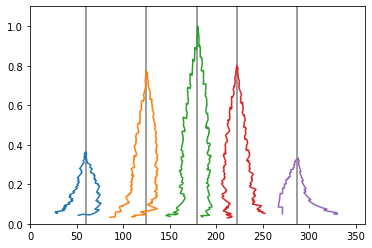

In [308]:
# check data and plot each lobe

for i in range(len(polar_lobe_angles)-2): # minus 2, because we added 0 and 360
    
    print(i)

    plt.plot(polar_angles[i], polar_radii[i])
    plt.vlines(x=polar_lobe_angles[i+1], ymin=0, ymax=1.1, color="grey") # add 1 to account for added 0 at beginning
    plt.xlim((0,360))
    plt.ylim((0,1.1))


In [393]:
###############################################
degrees = 4 # set the degrees of the polynomial

coefficients = [] # a list to store the coefficients for each polynomial for each, coeff stored as 1D arrays 

for i in range(len(polar_angles[0])): # for the number of points in each lobe
    
    curr_point_ind = int(i) # get current landmark index
    
    curr_angles = [] # list to store current angles of current landmark
    curr_radii = [] # list to store current radii of current landmark
    
    for j in range(len(polar_lobe_angles)-2): # for the number of lobes, -2 because we added 0 and 360
        
        curr_angles.append(polar_angles[j][i]) # for lobe j, get angle i
        curr_radii.append(polar_radii[j][i]) # for lobe j, get radius i
        
    # calculate polynomial function for the current landmark and get coefficients
    coef = np.polyfit(curr_angles, curr_radii, degrees) # fit a polynomial for the current landmark
    
    coefficients.append(coef) # append current coefficient array to list coefficients


In [430]:
# calculate angle points to model over for each landmark given new, desired angles
# start with lobe tips, and use np.linspace to create interpolated points between tip angles
# at an abitrarily high density. then, find closet index of interpolated space to new desired angles
# using indices of tip

#####################################################
new_lobe_num = 7 # SELECT THE DESIRED NUMBER OF LOBES

num_spaces = new_lobe_num + 1 # the number of divisions is 1 + the number of lobes
angle_val = 360/num_spaces # divide 360 by the number of spaces between lobes

angle_list = [] # a list to store the desired angles
ang = 0 # a counter, starting at 0

while ang < 360: # while the counter is < 360
    
    ang += angle_val # add the angular value to counter
    angle_list.append(ang) # append the angle
    
angle_list = angle_list[0:-1] # remove the last list element which is always 360

#################################################################################
num_inter_points = 100 # SELECT THE NUMBER OF POINTS TO INTERPOLATE BETWEEN ANGLES

inter_angles = [] # a list to store the interpolated angles

for i in range(len(polar_lobe_angles)-1): # always starting on the angle up to the end of the interval
    
    start_ind = i  # start index
    end_ind = i + 1 # end index
    interval_points = np.linspace(polar_lobe_angles[start_ind], polar_lobe_angles[end_ind], num_inter_points) # interpolate
    inter_angles.append( interval_points[0:-1].tolist() ) # remove last element, because we START on the angle
    
inter_angles = [item for sublist in inter_angles for item in sublist] # flatten the list of lists

# find the indices closest to the angles

index_list = [] # create a list to store the indices to closest to each desired angle

for i in range(len(angle_list)): # for each desired angle
    
    curr_ang = angle_list[i] # select current angle
    
    distances = [] # create list to store distances from each interpolated point
    
    for j in range(len(inter_angles)): # for each interpolated point
        
        distances.append(abs(curr_ang - inter_angles[j])) # append the distance of the interpolated point to the desired angle
        
    index_list.append(distances.index(min(distances))) # append the index of the minimum value

    
# now that we have the indices to use for the deisred angles, we need to create
# lists of interpolated points for each pseudolandmark, just like we did for the tip points

interpolated_angles = [] # list of lists, for each pseudolandmark, the interpolated angles

for j in range(len(polar_angles[0])): # for the number of pseudolandmarks

    pseudo_angle_list = [] # list to store the angles of the current pseudolandmark

    for i in range(len(polar_angles)): # for each lobe
        
        pseudo_angle_list.append(polar_angles[i][j]) # append the angle of the pseudolandmark for the current lobe
        
    pseudo_angle_list.insert(0,0) # add 0 at beginning for intervals 
    pseudo_angle_list.append(360) # add 360 at end for intervals 
    
    inter_pseudo_angles = []
    
    for k in range(len(pseudo_angle_list)-1): # always starting on the angle up to the end of the interval
    
        start_ind = k  # start index
        end_ind = k + 1 # end index
        interval_points = np.linspace(pseudo_angle_list[start_ind], pseudo_angle_list[end_ind], num_inter_points) # interpolate
        inter_pseudo_angles.append( interval_points[0:-1].tolist() ) # remove last element, because we START on the angle
        
    inter_pseudo_angles = [item for sublist in inter_pseudo_angles for item in sublist] # flatten the list of lists
        
    interpolated_angles.append(inter_pseudo_angles) # append the interpolated angles for the current pseudolandmark
        

In [431]:
######################################################################
# the following are the relevant resources to now model the new lobes:

# coefficients: a list of arrays of coefficients of model for each pseudolandmark
# interpolated_angles: a list of lists of interpolated angles for each pseudolandmark
# index_list: a list of indices for the desired angles

modeled_angles = [] # a list of lists, for each pseudolandmark, the modeled angle values
modeled_radii = [] # a list of lists, for each pseudolandmark, the modeled radius values

for i in range(len(coefficients)): # for each pseudolandmark
    
    current_angles = [] # list of current angles to model for the current psuedolandmark
    
    for j in range(len(index_list)): # for each index
        
        current_angles.append(interpolated_angles[i][index_list[j]]) # append the associated pseudolandmark angle
        
    coef = coefficients[i] # the coefficients of the model for the current pseudolandmark
    polyfunc = np.poly1d(coef) # create polynomial functio n
    current_radii = polyfunc(current_angles) # get radii of current angles
    
    modeled_angles.append(current_angles) # append modeled angles for each pseudolandmark to list
    modeled_radii.append(current_radii.tolist()) # append modeled radii for each pseudolandmark to list
    
    

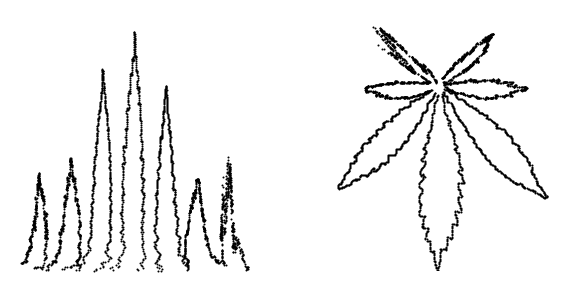

In [432]:
# make a plot

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

for i in range(len(modeled_angles)):
    
    plt.scatter(modeled_angles[i],modeled_radii[i], s=1, c="k")
    plt.xlim((0,360))
    plt.ylim((0,1.1))
    plt.axis("off")
    
plt.subplot(1,2,2)

for i in range(len(modeled_angles)):
    
    x = modeled_radii[i]*np.sin(np.radians(modeled_angles[i]))
    y = modeled_radii[i]*np.cos(np.radians(modeled_angles[i]))
        
    plt.scatter(x,y, s=1, c="k")
    plt.gca().set_aspect("equal")
    plt.xlim((-0.7,0.7))
    plt.ylim((-1,0.4))
    plt.axis("off")
    
plt.savefig("x_" + str(new_lobe_num) + ".jpg")


# `radial_leaf` function

**A function `radial_leaf` that takes inputs of:**

1. leaf trace coordinates
2. landmark coordinates
3. number of points to interpolate for the trace
4. number of landmarks (interpolated points within each leaflet)
5. polynomial degree to model each landmark across leaflets in polar coordinates
6. frames (or x values) to model across the leaf, apportioned to intervals between leaflets by rounding

**The function returns:**

1. overall modeled x and y values. for both x and y values, this is a double list of lists structured first by frame, and the for each frame, modeled values for each landmark. models are using polar coordinates
2. interpolated trace lists for plotting
3. landmark lists that have been aligned to the trace (for plotting)

**IMPORTANT NOTE:** for now, only the right side of leaves is considered. The `np.arctan` function returns phi values only between +/- pi/2. There are also with problems in quadrant 4, in addition to 2 and 3, as well. This is a bug to figure out in the future, but is circumvented here by only considering the right side of leaves for the radial modeling step.

In [1]:
import numpy as np # for text file data
from PIL import Image # for displaying images
from scipy.interpolate import interp1d # for interpolating points
import matplotlib.pyplot as plt # for plotting
%matplotlib inline

# first define a function to return equally spaced, interpolated points

def interpolation(x, y, number): 

    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

# define functions for converting between cartesian and polar coordinates

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

########################################
########################################
########################################
########################################

# now define the model_leaf function

def radial_leaf(trace_file, landmarks_file, num_points, num_land, deg, frames):

########################################
########################################
########################################
########################################

    trace_xvals, trace_yvals = interpolation(trace_file[:,0],trace_file[:,1],num_points)

    #############################
    # find interpolated trace points that correspond to the landmarks
    #############################

    # find the corresponding trace coordinates for each landmark
    # record new landmark coord values
    # record landmark index values for trace values

    land_xvals = [] # list to store new landmark x vals
    land_yvals = [] # list to store new landmark y vals
    land_indices = [] # list to store index values

    for i in range(landmarks_file.shape[0]):

        landx = landmarks_file[i,0] # select current landmark
        landy = landmarks_file[i,1] 

        distances = [] # list to store distances of current landmark with each trace coord

        for j in range(len(trace_xvals)): # for each trace coord

            tracex = trace_xvals[j]
            tracey = trace_yvals[j]

            d = np.sqrt( (landx-tracex)**2 + (landy-tracey)**2 ) # find distance to each landmark

            distances.append(d) # append to distances

        min_val = np.min(distances) # find min distance value
        min_ind = distances.index(min_val) # find min index value among trace coords

        land_xvals.append(trace_xvals[min_ind]) # append new landmark coord and index vals
        land_yvals.append(trace_yvals[min_ind])
        land_indices.append(min_ind)

    #############################
    # create same number of interpolated landmarks for each lobe, using beginning, tip, and end as true landmarks
    #############################

    num_lobes = int((len(land_indices)-1)/2) # get number of lobes in the leaf

    lobe_xvals = []
    lobe_yvals = []

    for i in range(num_lobes): # for the number of lobes

        begin = i*2 # current lobe beginning index
        tip = i*2+1 # current lobe tip index
        end = i*2+2 # current lobe end index

        first_half_x = trace_xvals[land_indices[begin]:land_indices[tip]] # isolate first half of traced lobe
        first_half_y = trace_yvals[land_indices[begin]:land_indices[tip]]
        second_half_x = trace_xvals[land_indices[tip]:land_indices[end]]  # isolate second half of traced lobe
        second_half_y = trace_yvals[land_indices[tip]:land_indices[end]]

        first_landx, first_landy = interpolation(first_half_x, first_half_y, int(num_land/2)) # interpolate half number of landmarks to first half
        second_landx, second_landy = interpolation(second_half_x, second_half_y, int(num_land/2)) # interpolate half number of landmarks to second half

        lobex = list(first_landx) + list(second_landx) # combine xvals of first and second half of lobe
        lobey = list(first_landy) + list(second_landy) # combine yvals of first and second half of lobe

        lobe_xvals.append(lobex) # append a list with the interpolated coordinate values for each lobe
        lobe_yvals.append(lobey)

    lobex_arr = np.array(lobe_xvals) # turn list of lists of lobe values into arrays
    lobey_arr = np.array(lobe_yvals)

    #############################
    # for frame number, apportion frames approximately equally between intervals by rounding
    #############################

    num_lobes = int((len(land_indices)-1)/2) # get number of lobes in the leaf

    inv_num = np.linspace(0,frames,num_lobes) # calculate interval number (between lobe spaces)

    round_inv = [int(round(item, 0)) for item in inv_num] # rounds the above list to number of frames for each interval

    intervals = [] # a list of lists, for each interval, a list of the frames it is apportioned

    for r in range(len(round_inv)-1):

        inv_begin = round_inv[r]
        inv_end = round_inv[r+1]

        interval = []

        for n in range(inv_begin, inv_end):

            interval.append(n)

        intervals.append(interval)

    #############################
    # create double list of lists, for each frame, a list of all modeled values
    #############################

    #################

    # First, translate coords to origin then convert to polar coords

    origin = landmarks_file[0] # calculate origin from first coords
    trans_lobesx = lobex_arr-origin[0] # translate lobe xvals to origin
    trans_lobesy = lobey_arr-origin[1] # translate lobe yvals to origin
    rho, phi = cart2pol(trans_lobesx, trans_lobesy) # convert x and y arrays to rho and phi

    #################

    overall_phis = [] # a double list of lists, for each frame, a list of phi values
    overall_rhos = [] # a double list of lists, for each frame, a list of rho values

    for f in range(frames): # for each frame

        curr_frame_phis = [] # a list of modeled values for each landmark for the current frame
        curr_frame_rhos = []

        for l in range(num_land):

            # for current landmark l, code below recalculates and apportions phis across leaf
            # this code is repetitive, but puts frame number before calculating modeled values
            all_phis = []
            for k in range(len(intervals)):
                curr_inv = intervals[k]
                inv_len = len(curr_inv)
                curr_phis = np.linspace(phi[k,l],phi[k+1,l], inv_len)
                all_phis.append(curr_phis)
            flat_all_phis = []
            for i in range(len(all_phis)):
                curr_list = all_phis[i]
                for j in range(len(curr_list)):
                    flat_all_phis.append(curr_list[j])

            # isolate the current xval for the current frame, for the current landmark
            curr_phi = flat_all_phis[f]

            # recalculates polynomial function for the current landmark l
            coef = np.polyfit(phi[:,l],rho[:,l],deg) # fit a polynomial for the current landmark
            polyfunc = np.poly1d(coef) # create polynomial function

            # for the current frame and landmark, find modeled value for the calculated xval
            modeled_val = polyfunc(curr_phi) 

            curr_frame_phis.append(curr_phi) # append current phi
            curr_frame_rhos.append(modeled_val) # append current modeled val

        overall_phis.append(curr_frame_phis) # append list of xvals for current frame
        overall_rhos.append(curr_frame_rhos) # append list of yvals for current frame

    #############################
    # convert polar back to cartesian and translate back to original location
    #############################

    trans_overall_xvals, trans_overall_yvals = pol2cart(overall_rhos, overall_phis)

    overall_xvals = trans_overall_xvals + origin[0] # translate lobe xvals back to original location
    overall_yvals = trans_overall_yvals + origin[1] # translate lobe yvals back to original location
    
    return overall_xvals, overall_yvals, trace_xvals, trace_yvals, land_xvals, land_yvals



# data for modeling different *Cannabis* leaves

various leaf outlines of *sativa*, *indica*, and hybrid varieties

In [53]:
# set the parameters

num_points = 200 # number of trace points to interpolate
num_land = 20 # number of landmarks for each lobe, make it even number
deg = 2 # degrees of fitted polynomial
frames = 200 # number of frames across the leaf to model

# load files

### A ###

Atrace = np.loadtxt("./data/Atrace.txt" ) # polyline trace
Aland = np.loadtxt("./data/Aland.txt" ) # leaflet landmarks

### B ###

Btrace = np.loadtxt("./data/Btrace.txt" ) # polyline trace
Bland = np.loadtxt("./data/Bland.txt" ) # leaflet landmarks

### C ###

Ctrace = np.loadtxt("./data/Ctrace.txt" ) # polyline trace
Cland = np.loadtxt("./data/Cland.txt" ) # leaflet landmarks



# use function radial_leaf to retrieve data

overAX, overAY, traceAX, traceAY, landAX, landAY = radial_leaf(Atrace, Aland, num_points, num_land, deg, frames)

overBX, overBY, traceBX, traceBY, landBX, landBY = radial_leaf(Btrace, Bland, num_points, num_land, deg, frames)

overCX, overCY, traceCX, traceCY, landCX, landCY = radial_leaf(Ctrace, Cland, num_points, num_land, deg, frames)




# Visualize data

In [54]:
######################
# specify data to plot

outlineAX = traceAX
outlineAY = traceAY
ptAX = landAX
ptAY = landAY
leafAX = overAX
leafAY = overAY

outlineBX = traceBX
outlineBY = traceBY
ptBX = landBX
ptBY = landBY
leafBX = overBX
leafBY = overBY

outlineCX = traceCX
outlineCY = traceCY
ptCX = landCX
ptCY = landCY
leafCX = overCX
leafCY = overCY

######################

photo_file = Image.open("./cannabis_leaves.jpg", 'r')

outline_c = "green"
outline_lw = 2

land_c = "dodgerblue"
land_s = 80

point_c = "magenta" # modeled point parameters
point_lw = 2

highlight_c = "orange" # highlight point parameters
highlight_s = 80

for f in range(frames):

    fig = plt.figure(figsize = (12*1.2,6*1.2), facecolor="black")

    plt.imshow(photo_file, cmap="gist_gray")
    
    ### A ###

    plt.plot(outlineAX,outlineAY, c=outline_c, lw=outline_lw)
    plt.scatter(ptAX,ptAY, c=land_c, s=land_s)

    plt.plot(leafAX[f], leafAY[f], c=point_c, lw=point_lw)
    plt.scatter(leafAX[f][0], leafAY[f][0], c=highlight_c, s=highlight_s)
    plt.scatter(leafAX[f][10], leafAY[f][10], c=highlight_c, s=highlight_s)
    plt.scatter(leafAX[f][19],  leafAY[f][19], c=highlight_c, s=highlight_s)
    
    ### B ###
    
    plt.plot(outlineBX,outlineBY, c=outline_c, lw=outline_lw)
    plt.scatter(ptBX,ptBY, c=land_c, s=land_s)
    
    plt.plot(leafBX[f], leafBY[f], c=point_c, lw=point_lw)
    plt.scatter(leafBX[f][0], leafBY[f][0], c=highlight_c, s=highlight_s)
    plt.scatter(leafBX[f][10], leafBY[f][10], c=highlight_c, s=highlight_s)
    plt.scatter(leafBX[f][19],  leafBY[f][19], c=highlight_c, s=highlight_s)
    
    ### C ###
    
    plt.plot(outlineCX,outlineCY, c=outline_c, lw=outline_lw)
    plt.scatter(ptCX,ptCY, c=land_c, s=land_s)
    
    plt.plot(leafCX[f], leafCY[f], c=point_c, lw=point_lw)
    plt.scatter(leafCX[f][0], leafCY[f][0], c=highlight_c, s=highlight_s)
    plt.scatter(leafCX[f][10], leafCY[f][10], c=highlight_c, s=highlight_s)
    plt.scatter(leafCX[f][19],  leafCY[f][19], c=highlight_c, s=highlight_s)
    
    
    #############
    
    plt.axis("off")
    #plt.ylim(670,-10)
    #plt.xlim(-10,1100)
    
    filename = "./plots/frame"+str(f)+".jpg"
        
    plt.savefig(filename, facecolor=fig.get_facecolor()) 
    plt.close()